In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm


from helpers.physics_functions import get_bins
from helpers.stats_functions import parametric_fit, curve_fit_m_inv, calculate_test_statistic, integral
from helpers.evaluation import get_median_percentiles

from helpers.stats_functions import calculate_test_statistic
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')



{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [20]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 
    
feature_id = "mix_2"
bootstrap_flow = 0 # don't change this from 0

train_samesign = False
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "OS": 
    alt_test_data_id = "SS"
elif train_data_id == "SS": 
    alt_test_data_id = "OS"

configs = "CATHODE_8"


# pickles contain all the results from the BDT training
working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/{configs}/"
pickle_save_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/pickles/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/"
plot_data_dir = "plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1
n_folds = 5

In [21]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
bkg_fit_degree = 5

In [22]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(SB_left, SB_right)
print(SR_left, SR_right)


data_prefix = f"upsilon_{train_data_id}"
print(data_prefix)

5.0 16.0
9.0 10.6
upsilon_OS


## Load in the BDT results

In [23]:

print(f"Loading data from {flow_training_dir}")
with open(f"{flow_training_dir}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Loading data from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/models/bootstrap0_OS/mix_2/CATHODE_8/
Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


In [24]:
# if train_samesign = False, this loads in the OS test data
# test 

fit_types = {3: "cubic", 4: "quartic", 5: "quintic", 6: "sextic", 7: "septic", 8: "octic", 9: "nonic", 10: "decic"}


def load_in_pseudoexperiments(file_string, num_pseudoexps):

    master_dict = {}

    with open(f"{pickle_save_dir}/{file_string}_{fit_types[bkg_fit_degree]}_{num_bins_SR}_0_1", "rb") as ifile:
        loc_dict = pickle.load(ifile)
    master_dict = {**loc_dict}
    # load in the bootstraps
    for i in range(1, num_pseudoexps):
        with open(f"{pickle_save_dir}/bkg_samples/bootstrap{i}/{file_string}_{fit_types[bkg_fit_degree]}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
            master_dict[i] = loc_dict[0]
    return master_dict

num_to_plot = num_pseudoexperiments

all_test_data_splits = load_in_pseudoexperiments("all_test_data_splits", num_to_plot)
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
all_scores_splits = load_in_pseudoexperiments("all_scores_splits", num_to_plot)
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
all_alt_data_splits = load_in_pseudoexperiments("all_alt_data_splits", num_to_plot)
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
all_alt_scores_splits = load_in_pseudoexperiments("all_alt_scores_splits", num_to_plot)

print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_flow}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_flow}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)

True
True
True
True


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
import pickle
import matplotlib.pyplot as plt

path_to_OS_data = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_12_03/processed_data/data_noIsoCut_noPreproc_OS_test_band_data"
with open(path_to_OS_data, "rb") as infile:
    data = pickle.load(infile)
    SR_data_OS = data["SR"]['skimmed_data_2016H_30555_nojet']
    SBL_data_OS = data["SBL"]['skimmed_data_2016H_30555_nojet']
    SBH_data_OS = data["SBH"]['skimmed_data_2016H_30555_nojet']





## Plot histograms for a small number of FPR thresholds

In [26]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]


# Save the FPR thresholds
with open(f"{plot_data_dir}{data_prefix}_fpr_thresholds", "wb") as ofile:
    pickle.dump(fpr_thresholds, ofile)

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

In [27]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    # ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)


In [28]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, 
                              mass_scalar, fit_degree, title, SB_left, SR_left, SR_right, SB_right, 
                              n_folds= 5, take_score_avg=True,):
    

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_degree"] = fit_degree
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []


    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    # Get a list of all possible cuts for the feature


    all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
    all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]

    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
    

        # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))




    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)



    for t, threshold in enumerate(fpr_thresholds):
        

                    # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)

        
        # plot the fit function
        plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, parametric_fit, [SB_left, SB_right], popt, pcov, color = f"C{t}")
        # calculate significance of bump
        S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = fit_degree, starting_guess = popt)
        print(threshold, S, B, np.sqrt(q0))
        bin_width = (SR_right - SR_left)/num_bins_SR
        print(integral(SR_left, SR_right, bin_width, *popt))


        total_events = len(filtered_masses)



        label_string = str(round(100*threshold, 2))+"% FPR: "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)



    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_degree}-degree Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.01, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)


    # Do the thing for the pre-isolation data
    filtered_masses = np.concatenate((SR_data_OS["dimu_mass"], SBL_data_OS["dimu_mass"], SBH_data_OS["dimu_mass"]))

    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
    #print("chi2/dof:", chi2/n_dof)

    
    # plot the fit function
    plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"black")    
    function_with_band(ax, parametric_fit, [SB_left, SB_right], popt, pcov, color = f"black")
    S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = fit_degree, starting_guess = popt)
    print(S, B, np.sqrt(q0))
    print(popt)
    
    total_events = len(filtered_masses)
    label_string = "Pre-cut; "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))
    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"black",label = label_string, alpha = 0.75)
    plt.scatter(plot_centers_SB, y_vals, color = f"black")

    save_data["popts"].append(popt)
    save_data["pcovs"].append(pcov)
    save_data["significances"].append(np.sqrt(q0))
    save_data["filtered_masses"].append(filtered_masses)
    save_data["y_vals"].append(y_vals)
    
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    return save_data
    


<>:132: SyntaxWarning: invalid escape sequence '\m'
<>:132: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_987574/1472121362.py:132: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


1 83.90820222813863 1608.0917977718614 1.356272968221533
1730.21008361234
0.25 94.76895754157152 411.2310424584285 2.9285885292630955
440.4743064094983
0.1 113.26411709656338 161.73588290343662 5.1617469606074025
169.29757266119086
0.05 77.63198012104917 89.36801987895083 4.70979997002558
87.13494823222719
0.01 37.618593279382736 13.38140672061726 4.5858556528101015
7.967499105822002
0.005 7.365823034736733 14.634176965263267 1.7906412003310006
2.42993319250072
0.001 0.4641749558550452 2.535825044144955 0.2832130094054263
1.129199913411081
2942.3461201272503 3599.6538798727497 28.415419414379006
[ 2.38151722e+02  2.29121212e+02 -5.60803758e+01  5.35821803e+00
 -2.36583943e-01  4.04809890e-03]
Saved Data to plot_data/upsilon_OS_histogram_data_5_12.pickle


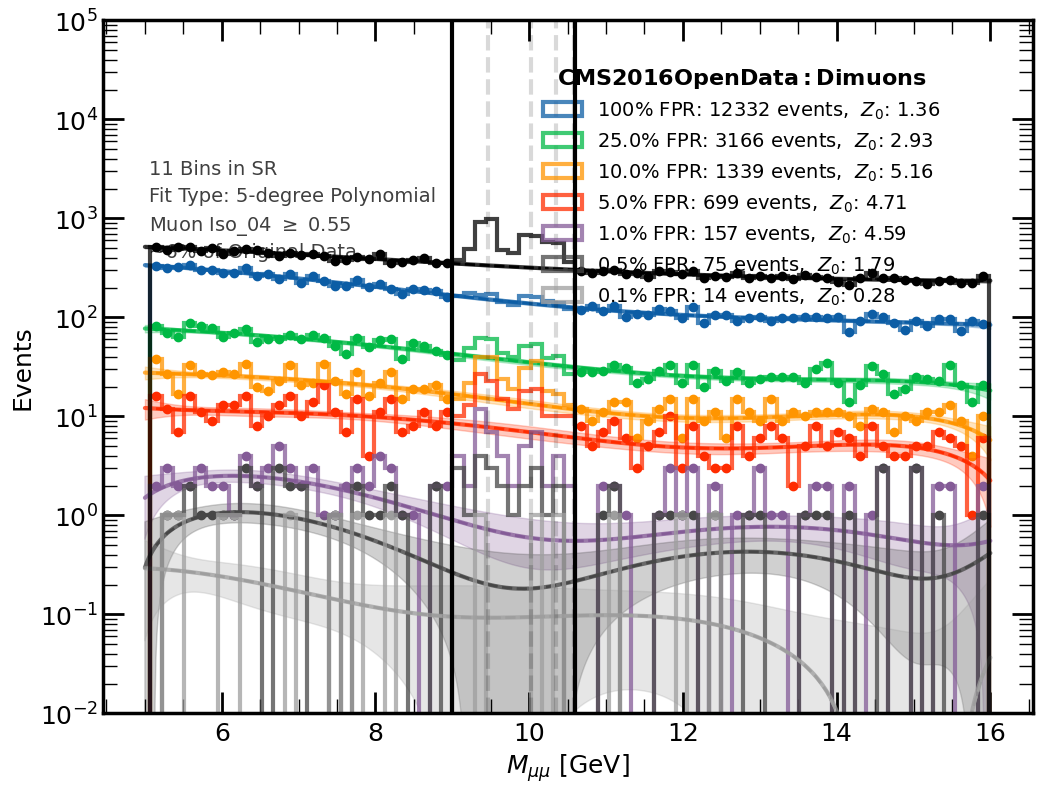

In [29]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
pseudo_e_to_plot = 0
save_data = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, bkg_fit_degree,f"upsilon OS\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

print("Saved Data to " + f"{plot_data_dir}{data_prefix}_histogram_data_{bkg_fit_degree}_{num_bins_SR}.pickle")

1 35.94921060180741 953.0507893981926 0.7564721854544897
1045.7093163912466
0.25 22.961556936803618 242.03844306319638 0.954984471426695
266.5401910466941
0.1 -0.2633679613857254 99.26336796138573 0.0
108.33034652765686
0.05 1.515664883779678 57.48433511622032 0.14713847971247088
56.16934480377336
0.01 -0.4358594510019742 16.435859451001974 0.0
11.721205629492284
0.005 -0.8316087831988117 8.831608783198812 0.0
6.093433891916133
0.001 0.08146490747138457 0.9185350925286154 0.08378865574919869
0.010679488424685248
2942.3461201272503 3599.6538798727497 28.415419414379006
[ 2.38151722e+02  2.29121212e+02 -5.60803758e+01  5.35821803e+00
 -2.36583943e-01  4.04809890e-03]


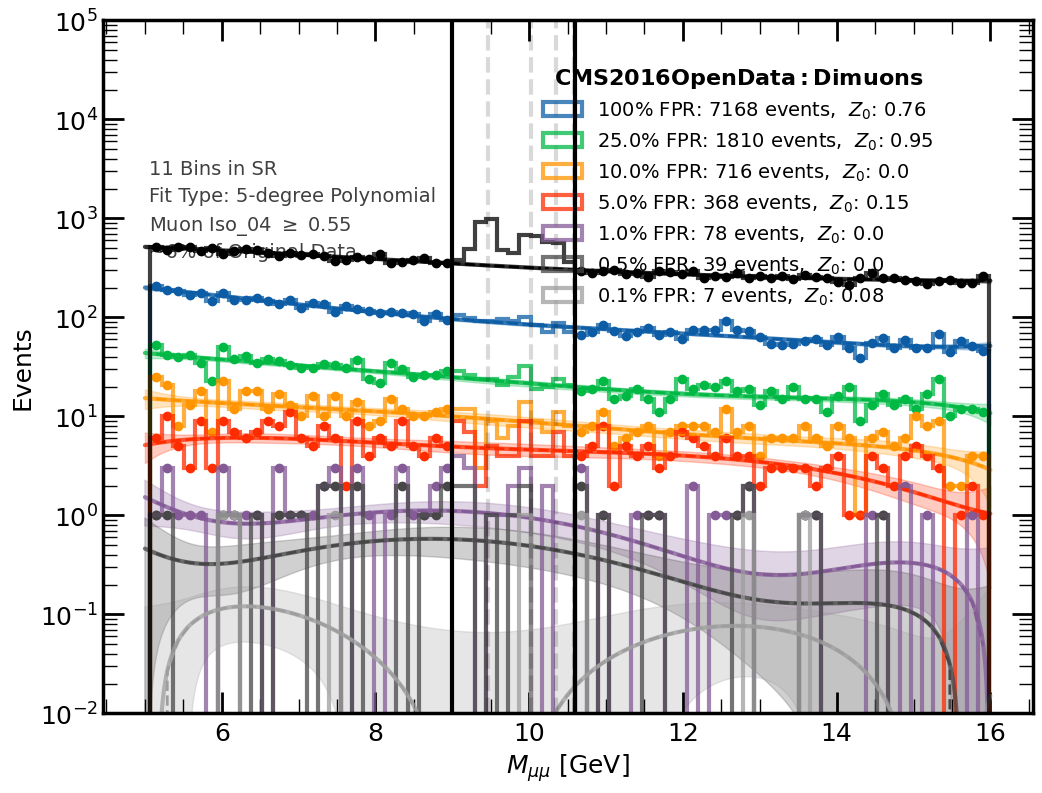

In [30]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], 
                                      all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], 
                                      scaler, bkg_fit_degree, f"upsilon SS",SB_left, SR_left, SR_right, SB_right, 
                                      take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


# Feature Plots

In [31]:
from helpers.data_transforms import scaled_to_physical_transform

def plot_features(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):



    pre_isoation_cut_data = SR_data_OS

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["features"] = []

    n_features = len(feature_set) - 1
    nbins = 40

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-6, 0, nbins),
        "mu1_ip3d": np.logspace(-6, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
    }


    all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
    all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))

    all_features = {i:all_data[:,i] for i in range(n_features)}
    all_features = {i: scaled_to_physical_transform(all_features[i], preprocessing_info[feature_set[i]], cushion = 0.02).reshape(-1,1) for i in range(n_features)}
    

    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]

    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
    

        # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))


    
    
    fig, ax = plt.subplots(1, n_features, figsize = (5*n_features, 5))


    for i_feat in range(n_features):

        ax[i_feat].hist(pre_isoation_cut_data[feature_set[i_feat]], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = "black",label = "Pre-Isolation Cut", alpha = 0.75)


    
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_features = {i:[] for i in range(n_features)}

        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        for i_feat in range(n_features):

            # Apply the cut
            indices = (in_SR) & (all_scores >= best_feature_cut)
            filtered_features[i_feat] = all_features[i_feat][indices]

            # Get only the SR


        save_data["features"].append(filtered_features)

        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"% FPR"
            


            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
            ax[i_feat].set_yscale("log")
            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(1e-1, 5*1e3)

            ax[i_feat].tick_params(labelsize = 16)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])


           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (1.05, 0.4), fontsize = 16)

    ax[0].set_ylabel("Events", fontsize = 18)
    plt.subplots_adjust(wspace=0)
    
    return save_data

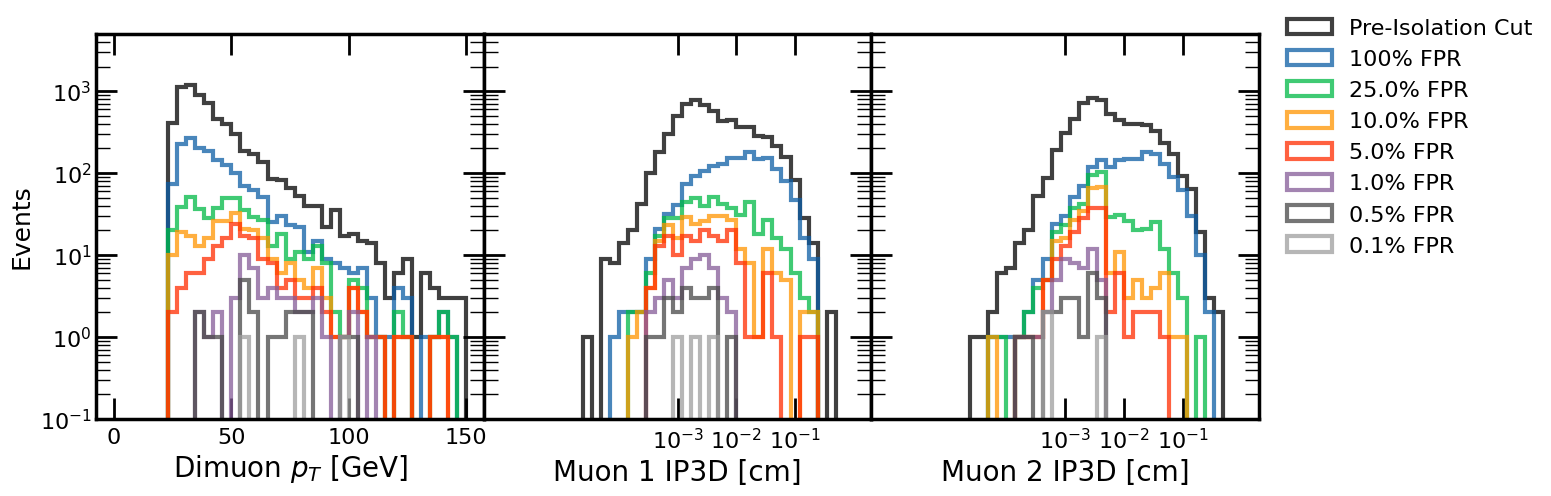

In [32]:
save_data = plot_features(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, SR_left, SR_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_feature_data_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

# Signficance Plots

In [33]:
n_folds = 5


# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)



        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, mass_scalar):

    num_experiments = num_pseudoexperiments
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))


    for pseudo_e in range(num_experiments):

        data_dict_by_fold = dataset_by_pseudo_e[pseudo_e]
        scores_dict_by_fold = scores_by_pseudo_e[pseudo_e]

        all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
        all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
        all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
        in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
        in_SBL = (all_masses < SR_left )
        in_SBH = (all_masses > SR_right )

        mass_SBL = all_masses[in_SBL]
        mass_SR = all_masses[in_SR]
        mass_SBH = all_masses[in_SBH]

        feature_SBL = all_scores[in_SBL]
        feature_SR = all_scores[in_SR]
        feature_SBH = all_scores[in_SBH]
        
        # Get a list of all possible cuts for the feature
        feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)

         # For each cut, calculate the number of signal and background events in the SR
        num_in_SBL = []
        num_in_SR = []
        num_in_SBH = []
        FPR = []
        for cut in feature_cut_points:
            num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
            num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
            num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))



        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

             # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, bkg_fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = bkg_fit_degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

        
    
    return significances



In [34]:
# Reformat alt to not have the 'alt' key
all_alt_data_splits_formatted = {}
all_alt_scores_splits_formatted = {}
for pseudo_e in range(num_pseudoexperiments):
    all_alt_data_splits_formatted[pseudo_e] = all_alt_data_splits[pseudo_e]["alt"]
    all_alt_scores_splits_formatted[pseudo_e] = all_alt_scores_splits[pseudo_e]["alt"]



In [35]:
significances = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances, ofile)


significances_alt = get_classifier_metrics_high_stats(all_alt_data_splits_formatted, all_alt_scores_splits_formatted, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_alt_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances_alt, ofile)


On pseudo experiment 1...
S:  83.90820222813863 B:  1608.0917977718614 sqrt(q0):  1.356272968221533
S:  107.91602159688523 B:  1196.0839784031148 sqrt(q0):  1.9987331413789402
S:  99.10223995201375 B:  923.8977600479863 sqrt(q0):  2.3926944131557404
S:  127.49989077692499 B:  670.500109223075 sqrt(q0):  3.1047438483808683
S:  108.54563254614686 B:  523.4543674538531 sqrt(q0):  2.990110321578873
S:  105.94424743386526 B:  387.05575256613474 sqrt(q0):  3.345370584119128
S:  117.20295913528349 B:  277.7970408647165 sqrt(q0):  4.220201698393872
S:  137.06942058365124 B:  203.93057941634876 sqrt(q0):  5.537838008790394
S:  113.26411709656338 B:  161.73588290343662 sqrt(q0):  5.1617469606074025
S:  109.79609175225059 B:  116.20390824774941 sqrt(q0):  5.639844022251818
S:  81.8487858187302 B:  96.1512141812698 sqrt(q0):  4.761494382824345
S:  73.4781262950523 B:  79.5218737049477 sqrt(q0):  4.7228910566794555
S:  66.15488217622062 B:  57.845117823779375 sqrt(q0):  4.812663557652579
S:  65.123

KeyboardInterrupt: 

In [19]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_splits, mass_scalar, fit_degree, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0, random = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """
    num_experiments = num_pseudoexperiments
    fpr_thresholds = fpr_thresholds_finegrained
    S_yield = np.zeros((len(fpr_thresholds), num_experiments))
    B_yield = np.zeros((len(fpr_thresholds), num_experiments))
    background_errors = np.zeros((len(fpr_thresholds), num_experiments))
    significances = np.zeros((len(fpr_thresholds), num_experiments))



    for (e, pseudo_e) in enumerate(tqdm(range(num_experiments))):

        all_nfolds = np.concatenate([test_data_splits[pseudo_e][i] for i in range(n_folds)])
        

        if random:
            feature_of_interest = np.random.uniform(0, 1, len(all_nfolds[:,-1]))
        else:
            feature_of_interest = all_nfolds[:,index]


        masses = mass_scalar.inverse_transform(np.array(all_nfolds[:,-1]).reshape(-1,1))[:,0]



        if flip:
            feature_of_interest = -feature_of_interest
           

        # Split into SBL, SR, and SBH
        # print(masses.shape, feature_of_interest.shape)
        feature_SBL = feature_of_interest[masses < SR_left]
        feature_SR = feature_of_interest[(masses >= SR_left) & (masses <= SR_right)]
        feature_SBH = feature_of_interest[masses > SR_right]




        # Get a list of all possible cuts for the feature
        mass_SBL = masses[masses < SR_left]
        mass_SR = masses[(masses >= SR_left) & (masses <= SR_right)]
        mass_SBH = masses[masses > SR_right]



        feature_cut_points = np.linspace(np.min(feature_of_interest), np.max(feature_of_interest), 10000)

        FPR = []
        for cut in feature_cut_points:
            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))



        plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
        fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}



        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]
            # print(np.min(feature_of_interest), np.max(feature_of_interest), best_feature_cut)

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

    

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]


            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = fit_degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

    
    return significances


In [20]:
# for i in range(n_folds):
#     all_test_data_splits[pseudo_e][i][:,0] = all_test_data_splits[pseudo_e][i][:,1] + all_test_data_splits[pseudo_e][i][:,2]

In [40]:

feature_SIGs = {}
feature_SIGs_alt = {}

flip_features = [True, True, True, False] 



# Opposite Sign
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
    print(feature)
    feature_SIGs[feature] = feature_cut_ROCS(feature, all_test_data_splits, scaler, bkg_fit_degree, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs[feature], ofile)

# Same Sign
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
    print(feature)
    feature_SIGs_alt[feature] = feature_cut_ROCS(feature, all_alt_data_splits_formatted, scaler, bkg_fit_degree, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_alt_{feature}_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs_alt[feature], ofile)

  


dimu_pt


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90820222813863 B:  1608.0917977718614 sqrt(q0):  1.356272968221533
S:  -8.389065693040493 B:  1150.3890656930405 sqrt(q0):  0.0
S:  -38.696689807650614 B:  848.6966898076506 sqrt(q0):  0.0
S:  23.45250154730195 B:  607.547498452698 sqrt(q0):  0.6141710648571305
S:  34.943877383304994 B:  452.056122616695 sqrt(q0):  1.072778787377935
S:  23.541883650382147 B:  343.45811634961785 sqrt(q0):  0.8154885351791672
S:  23.48691106720395 B:  246.51308893279605 sqrt(q0):  1.1969708077602432
S:  7.670532720122708 B:  187.3294672798773 sqrt(q0):  0.3595958434009318
S:  -0.6966679618461455 B:  135.69666796184615 sqrt(q0):  0.0
S:  10.887270805490047 B:  96.11272919450995 sqrt(q0):  0.7008874398069088
S:  11.359640859694863 B:  65.64035914030514 sqrt(q0):  0.8695169726243647
S:  14.958240498570248 B:  50.04175950142975 sqrt(q0):  1.310340450275912
S:  12.224844405490863 B:  33.77515559450914 sqrt(q0):  1.310116552907292
S:  9.112320683890442 B:  21.88767931610956 sqrt(q0):  1.1910842154553964

100%|██████████| 1/1 [02:00<00:00, 120.44s/it]

S:  3.350021382519938e-05 B:  -3.350021382519938e-05 sqrt(q0):  0.013430881666250522


mu0_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_SIGs["CATHODE"] = significances
feature_SIGs_alt["CATHODE"] = significances_alt


In [ ]:



# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs[key][:,0]
    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])
    print("max observed significance", np.max(SIG_observed))

# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys()) 
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")


# Add the keys in a seperate column with filled color
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):
    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")


# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {bkg_fit_degree} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 10)


<>:32: SyntaxWarning: invalid escape sequence '\P'
<>:32: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_894563/408571566.py:32: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")
/tmp/ipykernel_894563/408571566.py:32: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


NameError: name 'newplot' is not defined

KeyError: 'mu0_ip3d'

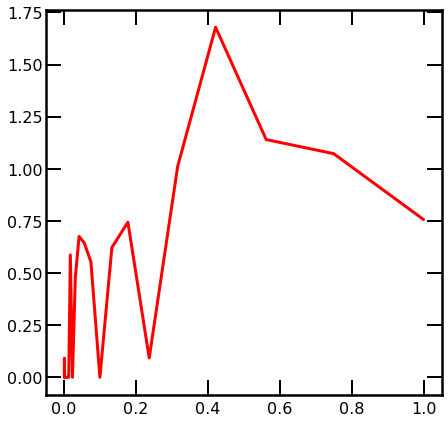

In [43]:
# same plot but for the alternative data

fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue", "black"]

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs_alt[key][:,0]



    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    if key == "random":
        ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = colors[i], alpha = 0.5)
      

# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys())
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")

# Add the keys in a seperate column with filled color

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d"]):

    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")

# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs_alt["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {bkg_fit_degree} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)

plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")




